###### 555-PS4-5                                                                 
###### Vikrant- 50247689



## HW-2.c Construct and train convolutional neural network for MNIST classification. 
   ### $-$ Regularize the training of the neural network through dropout. 
   ### $-$ Regularize the training of neural network through augment your selection of 1000 images 
   ### $-$ Rotating them for 1-3 degrees clockwise and counter clockwise, and 
   ### $-$ shifting them for 3 pixels in 8 different directions. 

## 1. Load all Libraries

In [ ]:
### https://github.com/yashk2810/MNIST-Keras/blob/master/Notebook/MNIST_keras_CNN-99.55%25.ipynb
#https://github.com/bstriner/keras-tqdm/issues/19
#https://github.com/bstriner/keras-tqdm
#https://blog.novatec-gmbh.de/keras-data-augmentation-for-cnn/
#https://yashk2810.github.io/Applying-Convolutional-Neural-Network-on-the-MNIST-dataset/
#https://github.com/yashk2810/Visualization-of-Convolutional-Layers/blob/master/Visualizing%20Filters%20Python3%20Theano%20Backend.ipynb
##-->https://github.com/leriomaggio/deep-learning-keras-tensorflow/blob/master/4.%20Convolutional%20Neural%20Networks/4.2.%20MNIST%20CNN.ipynb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils, to_categorical
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D
from keras.layers.advanced_activations import LeakyReLU 
from keras.preprocessing.image import ImageDataGenerator, random_shift, random_rotation, random_shear,random_zoom
import tensorflow as tf
from keras_tqdm import TQDMNotebookCallback
np.random.seed(25)

## 2. Read MNIST Data, select 1000 images( 100 each digit) and segregate in Train and Test

In [254]:
data = pd.read_csv('/Users/vikrant/GoogleDrive/CSE555-Intro2Pattern-WenDong/HW-45/mnist_train_nn1.csv')
datatest=pd.read_csv('/Users/vikrant/GoogleDrive/CSE555-Intro2Pattern-WenDong/HW-45/mnist_test_nn1.csv')

tmp=pd.DataFrame()
        
print("GETTING 1000 samples")
for i in range(10):
    loop = data.iloc[np.where(data.iloc[:,0] == i)]
            
            #https://stackoverflow.com/questions/29576430/shuffle-dataframe-rows
            #https://stackoverflow.com/questions/15923826/random-row-selection-in-pandas-dataframe
    loop1 = loop.sample(n=100).reset_index(drop=True)
            
            #print("No. of ROws, columns:" , len(loop1), "for digit:",i)
    tmp = tmp.append(loop1, ignore_index = True)

    
tmptest=pd.DataFrame()
        
print("GETTING 1000 samples")
for i in range(10):
    loop = datatest.iloc[np.where(datatest.iloc[:,0] == i)]
            
            #https://stackoverflow.com/questions/29576430/shuffle-dataframe-rows
            #https://stackoverflow.com/questions/15923826/random-row-selection-in-pandas-dataframe
    loop1 = loop.sample(n=100).reset_index(drop=True)
            
            #print("No. of ROws, columns:" , len(loop1), "for digit:",i)
    tmptest = tmptest.append(loop1, ignore_index = True)

    
tmp1=tmp.values
tmptest1=tmptest.values

np.random.shuffle(tmp1)
np.random.shuffle(tmptest1)


images = tmp1[:,1:]
#images = np.multiply(images, 1.0 / 255.0)
imagestest = tmptest1[:,1:]
#imagestest = np.multiply(imagestest, 1.0 / 255.0)
#images = images.astype(np.float64)
labls = tmp1[:,0]
lablstest = tmptest1[:,0]

#labels=labls.reshape(len(labls),1)
#labelstest=lablstest.reshape(len(lablstest),1)
'''
def dense_to_one_hot(labels_dense, num_classes):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot
'''
#labels = dense_to_one_hot(labls, 10)
labels = labels.astype(np.uint8)
#labelstest = dense_to_one_hot(lablstest, 10)
labelstest = labelstest.astype(np.uint8)

/Users/vikrant/anaconda3/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


GETTING 1000 samples
GETTING 1000 samples


## 3. Reshape the Images

In [255]:
X_train = np.reshape(images, (1000,28,28))
y_train = labls

X_test = np.reshape(imagestest, (1000,28,28))
y_test = lablstest

## 4. Display a random Image

Text(0.5,1,'Class 7')

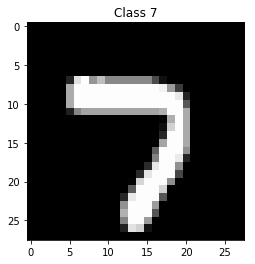

In [258]:
im = X_train[0]
plt.imshow(X_train[0], cmap='gray')
plt.title('Class '+ str(y_train[0]))

## 5. Reshape and Normalize the training and test images for feeding into CNN

In [259]:

X_train_ = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test_ = X_test.reshape(X_test.shape[0], 28, 28, 1)

X_train_ = X_train_.astype('float32')
X_test_ = X_test_.astype('float32')

X_train_/=255
X_test_/=255

X_train_.shape

(1000, 28, 28, 1)

/Users/vikrant/anaconda3/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


## 6 One Hot Encode the labels

In [286]:

number_of_classes = 10

Y_train = np_utils.to_categorical(y_train, number_of_classes)
Y_test = np_utils.to_categorical(y_test, number_of_classes)

y_train[0], Y_train[0]

(7, array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]))

## 7. Define the CNN Model
###  - Convolutional Layers
###  - Fully Connected Layer
###  - Introduce Dropout @ 20%

In [287]:
# Three steps to Convolution
# 1. Convolution
# 2. Activation
# 3. Polling
# Repeat Steps 1,2,3 for adding more hidden layers

# 4. After that make a fully connected network
# This fully connected network gives ability to the CNN
# to classify the samples

model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(28,28,1)))
model.add(Activation('relu'))
BatchNormalization(axis=-1)
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

BatchNormalization(axis=-1)
model.add(Conv2D(64,(3, 3)))
model.add(Activation('relu'))
BatchNormalization(axis=-1)
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
# Fully connected layer

BatchNormalization()
model.add(Dense(512))
model.add(Activation('relu'))
BatchNormalization()
model.add(Dropout(0.2)) #DROPOUT DEFINED at 20%
model.add(Dense(10))

# model.add(Convolution2D(10,3,3, border_mode='same'))
# model.add(GlobalAveragePooling2D())
model.add(Activation('softmax'))

In [288]:

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
activation_31 (Activation)   (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 24, 24, 32)        9248      
_________________________________________________________________
activation_32 (Activation)   (None, 24, 24, 32)        0         
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 10, 10, 64)        18496     
_________________________________________________________________
activation_33 (Activation)   (None, 10, 10, 64)        0         
__________

/Users/vikrant/anaconda3/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [264]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

## 8. Image Augmentation using Keras Function: ImageDataGenerator
### - rotating them for 1-3 degrees clockwise and counter clockwise: Defined by parameters "rotation_range=3"
### - shifting them for 3 pixels in 8 different directions: Define by parameters "width_shift_range=0.2, shear_range=0.5, height_shift_range=0.2"

#### Note: Detailed Examples of each of the Parameters is given later in the Notebook

In [275]:
gen = ImageDataGenerator(rotation_range=3, width_shift_range=0.2, shear_range=0.5,
                         height_shift_range=0.2, zoom_range=(0.9,1.1), horizontal_flip=False,\
                         vertical_flip=False, fill_mode='constant',cval=0)

test_gen = ImageDataGenerator()

In [280]:
train_generator = gen.flow(X_train_, Y_train, batch_size=32)
test_generator = test_gen.flow(X_test_, Y_test, batch_size=32)

/Users/vikrant/anaconda3/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


# Fitting the Model with 1k Training Images

In [283]:
# model.fit(X_train, Y_train, batch_size=128, nb_epoch=1, validation_data=(X_test, Y_test))# model. 

mfg = model.fit_generator(train_generator, steps_per_epoch=1000//32, epochs=10, 
                    validation_data=test_generator, validation_steps=1000//32, callbacks=[TQDMNotebookCallback(leave_inner=True, leave_outer=True)],)

HBox(children=(IntProgress(value=0, description='Training', max=10), HTML(value='')))

Epoch 1/10


HBox(children=(IntProgress(value=0, description='Epoch 0', max=31), HTML(value='')))

31/31 [==============================] - 5s 177ms/step - loss: 0.6118 - acc: 0.8034 - val_loss: 0.2173 - val_acc: 0.9325
Epoch 2/10


HBox(children=(IntProgress(value=0, description='Epoch 1', max=31), HTML(value='')))

10/31 [========>.....................] - ETA: 3s - loss: 0.5408 - acc: 0.8250

/Users/vikrant/anaconda3/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


31/31 [==============================] - 6s 191ms/step - loss: 0.5021 - acc: 0.8437 - val_loss: 0.2196 - val_acc: 0.9183
Epoch 3/10


HBox(children=(IntProgress(value=0, description='Epoch 2', max=31), HTML(value='')))

31/31 [==============================] - 6s 184ms/step - loss: 0.4139 - acc: 0.8690 - val_loss: 0.1894 - val_acc: 0.9446
Epoch 4/10


HBox(children=(IntProgress(value=0, description='Epoch 3', max=31), HTML(value='')))

31/31 [==============================] - 5s 173ms/step - loss: 0.4727 - acc: 0.8578 - val_loss: 0.1414 - val_acc: 0.9486
Epoch 5/10


HBox(children=(IntProgress(value=0, description='Epoch 4', max=31), HTML(value='')))

31/31 [==============================] - 6s 185ms/step - loss: 0.3334 - acc: 0.8911 - val_loss: 0.1182 - val_acc: 0.9627
Epoch 6/10


HBox(children=(IntProgress(value=0, description='Epoch 5', max=31), HTML(value='')))

31/31 [==============================] - 6s 186ms/step - loss: 0.3519 - acc: 0.8951 - val_loss: 0.1261 - val_acc: 0.9577
Epoch 7/10


HBox(children=(IntProgress(value=0, description='Epoch 6', max=31), HTML(value='')))

31/31 [==============================] - 6s 187ms/step - loss: 0.2965 - acc: 0.9111 - val_loss: 0.2379 - val_acc: 0.9264
Epoch 8/10


HBox(children=(IntProgress(value=0, description='Epoch 7', max=31), HTML(value='')))

31/31 [==============================] - 6s 180ms/step - loss: 0.3279 - acc: 0.8992 - val_loss: 0.1635 - val_acc: 0.9405
Epoch 9/10


HBox(children=(IntProgress(value=0, description='Epoch 8', max=31), HTML(value='')))

31/31 [==============================] - 6s 179ms/step - loss: 0.2980 - acc: 0.9063 - val_loss: 0.1598 - val_acc: 0.9476
Epoch 10/10


HBox(children=(IntProgress(value=0, description='Epoch 9', max=31), HTML(value='')))

31/31 [==============================] - 5s 174ms/step - loss: 0.2561 - acc: 0.9143 - val_loss: 0.1052 - val_acc: 0.9617


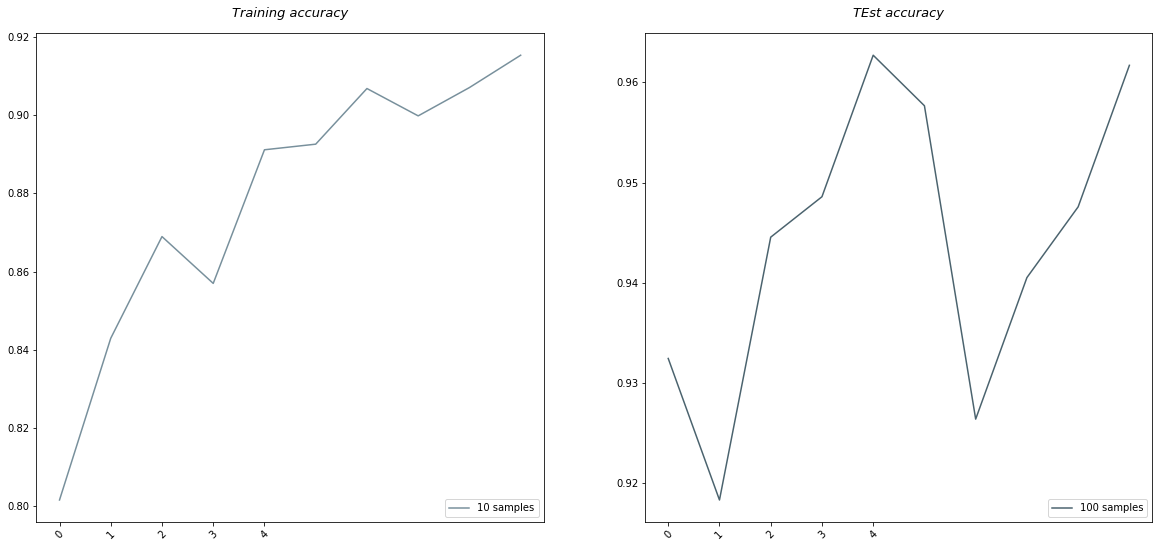

/Users/vikrant/anaconda3/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [290]:
figure = plt.figure(figsize=(20,9))
 
subplot = figure.add_subplot(1, 2, 1)
plt.plot(mfg.history['acc'], color='#78909c', label='10 samples')
#plt.ylim(0.8,1.09)
tick_marks = np.arange(5)
plt.xticks(tick_marks, range(5), rotation=45)
plt.title("Training accuracy", fontsize=13,fontweight=0, color='black', style='italic', y=1.02)
plt.legend(loc='lower right')

subplot = figure.add_subplot(1, 2, 2)
plt.plot(mfg.history['val_acc'], color='#4b636e', label='100 samples')
tick_marks = np.arange(5)
plt.xticks(tick_marks, range(5), rotation=45)
plt.title("TEst accuracy", fontsize=13,fontweight=0, color='black', style='italic', y=1.02)
plt.legend(loc='lower right')

# Examples of each of the ImageDataGenerator Parameters for reference

In [265]:

def plot_images(imgs, labels=None, rows=1, figsize=(20,8), fontsize=14):
    figure = plt.figure(figsize=figsize)
    cols = max(1,len(imgs) // rows-1)
    labels_present = False
    # checking if labels is a numpy array
    if type(labels).__module__ == np.__name__:
        labels_present=labels.any()
    elif labels:
        labels_present=True
    for i in range(len(imgs)):
        subplot = figure.add_subplot(rows, cols+1, i+1)
        # axis off, but leave a bounding box
        plt.tick_params(
            axis='both',
            which='both',
            bottom='off',
            top='off',
            left='off',
            right='off',
            labelbottom='off',
            labelleft='off')
        # plot labels if present
        if labels_present:
            subplot.set_title(labels[i], fontsize=fontsize)
        plt.imshow(imgs[i][:,:,0], cmap='Greys')
        
    plt.show()

/Users/vikrant/anaconda3/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [266]:
def get_random_sample(number_of_samples=10):
    x = []
    y = []
    for category_number in range(0,10):
        # get all samples of a category
        train_data_category = X_train[y_train==category_number]
        # pick a number of random samples from the category
        train_data_category = train_data_category[np.random.randint(train_data_category.shape[0], 
                                                                    size=number_of_samples), :]
        x.extend(train_data_category)
        y.append([category_number]*number_of_samples)
    
    return np.asarray(x).reshape(-1, 28, 28, 1), y

(100, 28, 28, 1)
(10, 10, 10)


/Users/vikrant/anaconda3/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


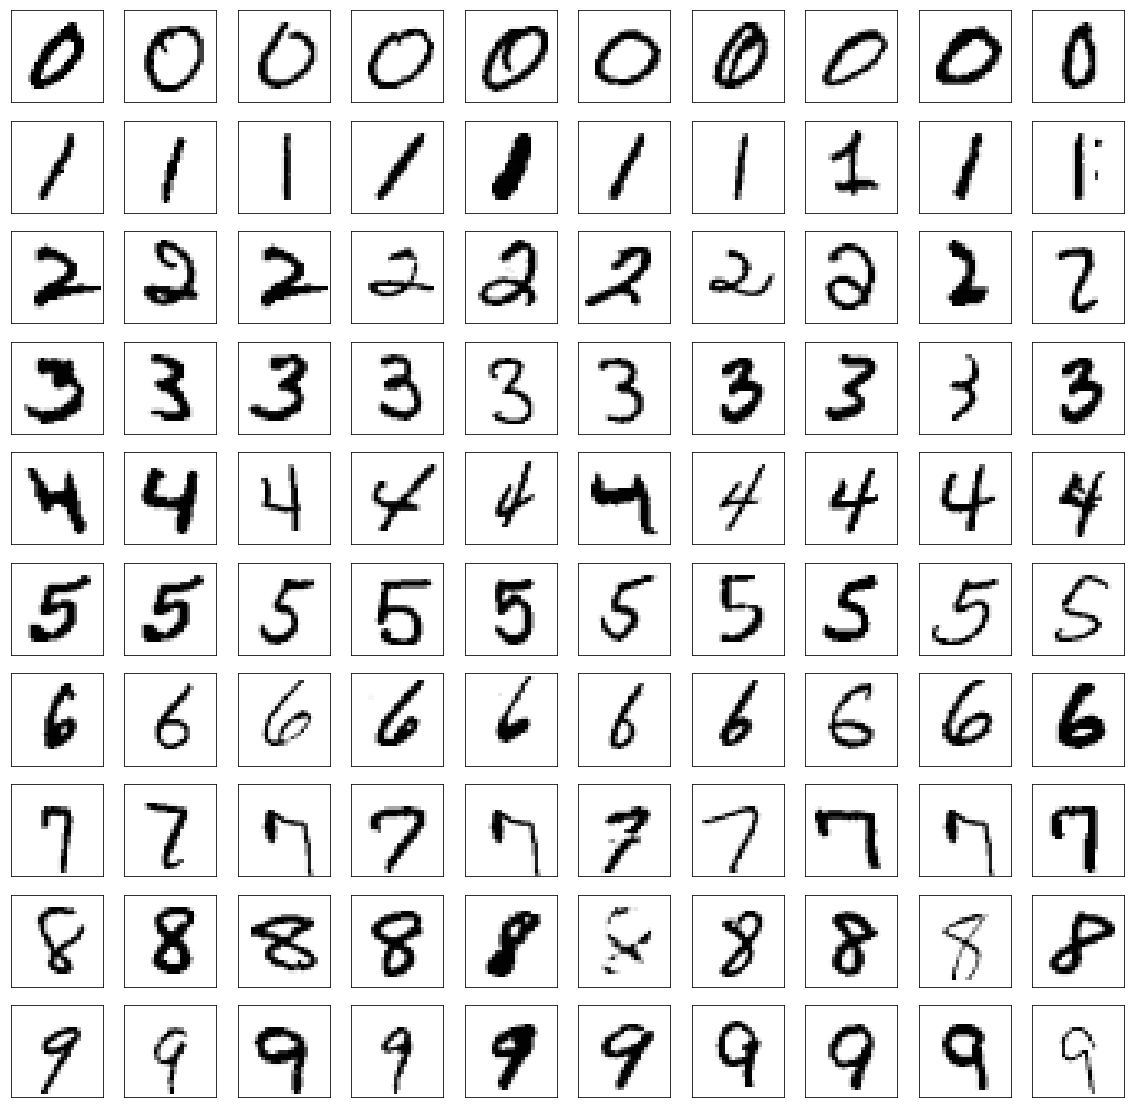

In [267]:
x_ten_samples, y_ten_samples = get_random_sample(number_of_samples=10)
 
y_ten_samples = to_categorical(y_ten_samples)
    
print(np.shape(x_ten_samples))
print(np.shape(y_ten_samples))
plot_images(x_ten_samples[0:100], rows=10, figsize=(20,20))

# IMAGE AUGMENTATION EXAMPLES

In [268]:
#Random Image
img = X_train_[2:3]
img.shape

(1, 28, 28, 1)

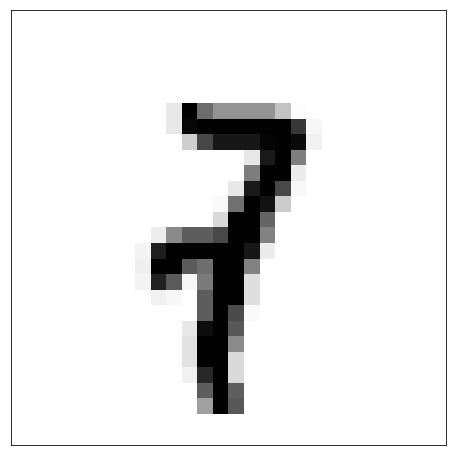

/Users/vikrant/anaconda3/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [269]:
plot_images(img)

## Shift in up -down , Left-right direction

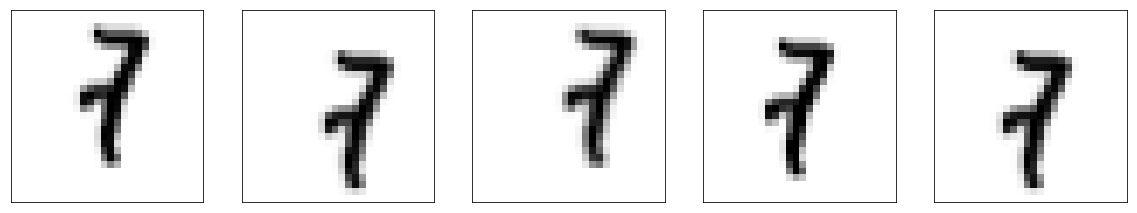

In [270]:
#https://blog.novatec-gmbh.de/keras-data-augmentation-for-cnn/
img_shifted = [ random_shift(
    img[0], 
    wrg=0.2, # 0.1 x imagesize (0.1 x 28 = 2.8) pixel left or right.
    hrg=0.2, #0.2 x imagesize (0.2 x 28 = 5.6) pixel up or down and 
    row_axis=0, 
    col_axis=1, 
    channel_axis=2, 
    fill_mode='constant',
    cval=0
) for _ in range(5) ]
plot_images(img_shifted)

## Random ROtation

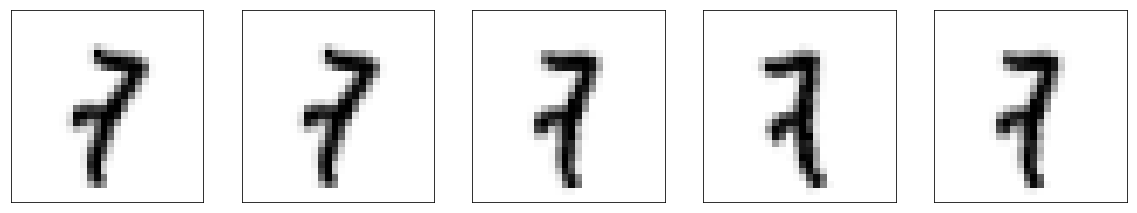

In [271]:
img_rotated = [ random_rotation(
    img[0], 
    20,# For Demo: max rotation of 20 degrees in clockwise or anticlockwise 
    row_axis=0, 
    col_axis=1, 
    channel_axis=2, 
        fill_mode='constant',
    cval=0
) for _ in range(5) ]
plot_images(img_rotated)

## Shear


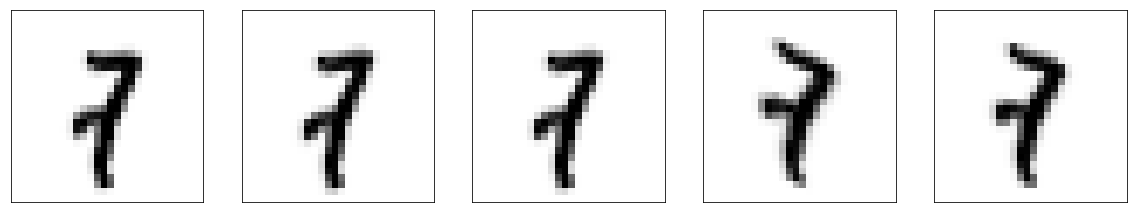

/Users/vikrant/anaconda3/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [272]:
img_sheared = [ random_shear(
    img[0],
    intensity=33,
    row_axis=0,
    col_axis=1,
    channel_axis=2,
    fill_mode='constant',
    cval=0
) for _ in range(5) ]
plot_images(img_sheared)

## ZOOM

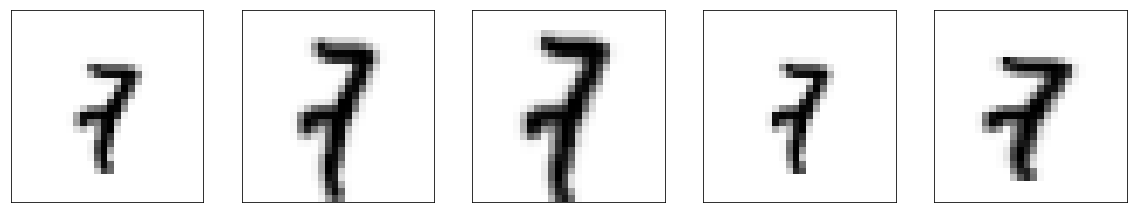

In [273]:

img_zoomed = [ random_zoom(
    img[0],
    zoom_range=(0.7,1.3),
    row_axis=0,
    col_axis=1,
    channel_axis=2,
    fill_mode='constant',
    cval=0
) for _ in range(5) ]
plot_images(img_zoomed)

/Users/vikrant/anaconda3/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


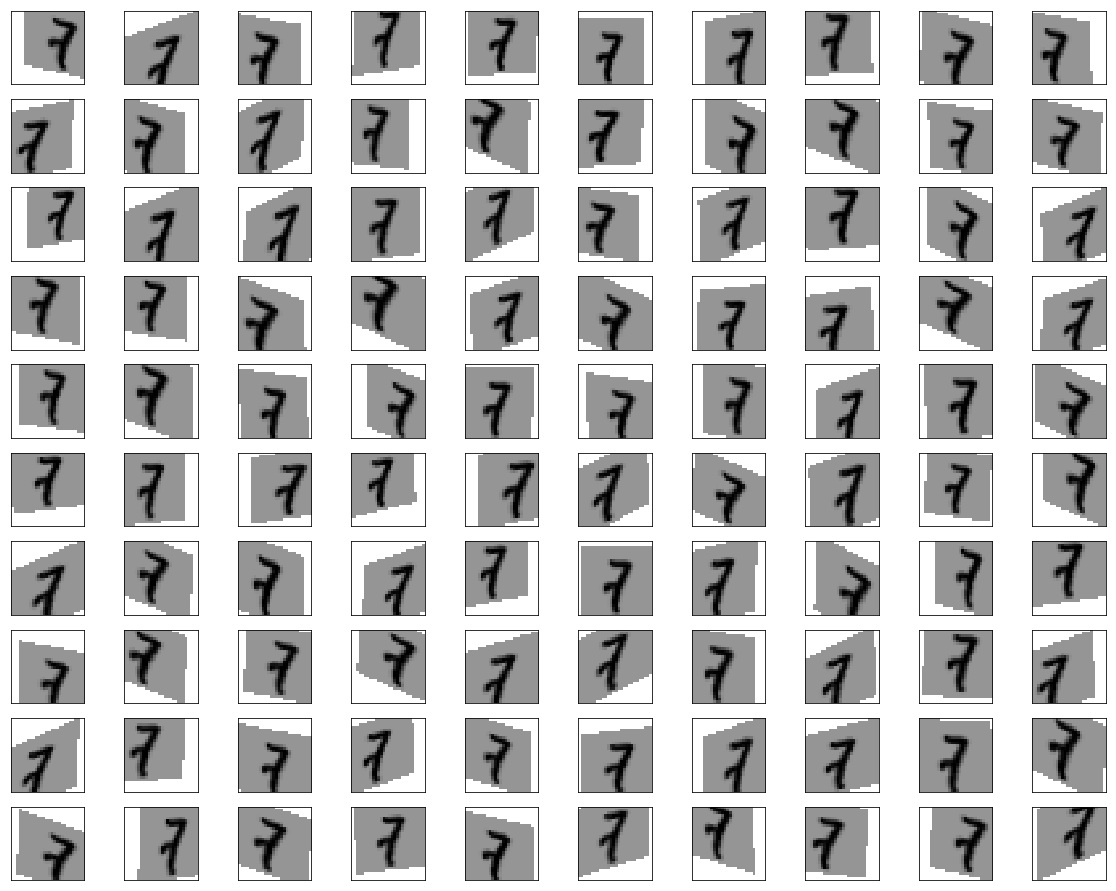

In [274]:

datagen = ImageDataGenerator(
        rotation_range=3,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=30,
        zoom_range=(0.9, 1.1),
        horizontal_flip=False,
        vertical_flip=False, 
        fill_mode='constant',
        cval=0
)
batches = 0
max_batches = 100
img_gen = []
for x_batch in datagen.flow((img + img.shape), batch_size=max_batches):
    img_gen.append(x_batch[0])
    batches += 1
    if batches >= max_batches:
        # generator loops indefinetly
        break
        
plot_images(img_gen, rows=10, figsize=(20,16))

In [174]:
gen = ImageDataGenerator(rotation_range=3, width_shift_range=0.2, shear_range=0.5,
                         height_shift_range=0.2, zoom_range=(0.9,1.1), horizontal_flip=False,\
                         vertical_flip=False, fill_mode='constant',cval=0)

test_gen = ImageDataGenerator()

In [175]:
train_generator = gen.flow(X_train_, Y_train, batch_size=64)
test_generator = test_gen.flow(X_test_, Y_test, batch_size=64)

# Fitting the Model with 60k training Images

In [188]:

# model.fit(X_train, Y_train, batch_size=128, nb_epoch=1, validation_data=(X_test, Y_test))# model. 

mfg = model.fit_generator(train_generator, steps_per_epoch=60000//64, epochs=5, 
                    validation_data=test_generator, validation_steps=10000//64, callbacks=[TQDMNotebookCallback(leave_inner=True, leave_outer=True)],)

HBox(children=(IntProgress(value=0, description='Training', max=5), HTML(value='')))

Epoch 1/5


HBox(children=(IntProgress(value=0, description='Epoch 0', max=937), HTML(value='')))

  3/937 [..............................] - ETA: 5:03 - loss: 0.0645 - acc: 0.9844

/Users/vikrant/anaconda3/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


937/937 [==============================] - 261s 278ms/step - loss: 0.0478 - acc: 0.9857 - val_loss: 0.0297 - val_acc: 0.9902
Epoch 2/5


HBox(children=(IntProgress(value=0, description='Epoch 1', max=937), HTML(value='')))

937/937 [==============================] - 257s 274ms/step - loss: 0.0459 - acc: 0.9864 - val_loss: 0.0245 - val_acc: 0.9928
Epoch 3/5


HBox(children=(IntProgress(value=0, description='Epoch 2', max=937), HTML(value='')))

937/937 [==============================] - 249s 266ms/step - loss: 0.0404 - acc: 0.9875 - val_loss: 0.0244 - val_acc: 0.9924
Epoch 4/5


HBox(children=(IntProgress(value=0, description='Epoch 3', max=937), HTML(value='')))

937/937 [==============================] - 251s 268ms/step - loss: 0.0382 - acc: 0.9886 - val_loss: 0.0211 - val_acc: 0.9931
Epoch 5/5


HBox(children=(IntProgress(value=0, description='Epoch 4', max=937), HTML(value='')))

937/937 [==============================] - 252s 269ms/step - loss: 0.0386 - acc: 0.9888 - val_loss: 0.0187 - val_acc: 0.9936


# Evaluate on 10K test Images

In [192]:
score = model.evaluate(X_test_, Y_test)
print()
print('Test accuracy: ', score[1])

 6528/10000 [==================>...........] - ETA: 4s

/Users/vikrant/anaconda3/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


10000/10000 [==============================] - 13s 1ms/step

Test accuracy:  0.9936


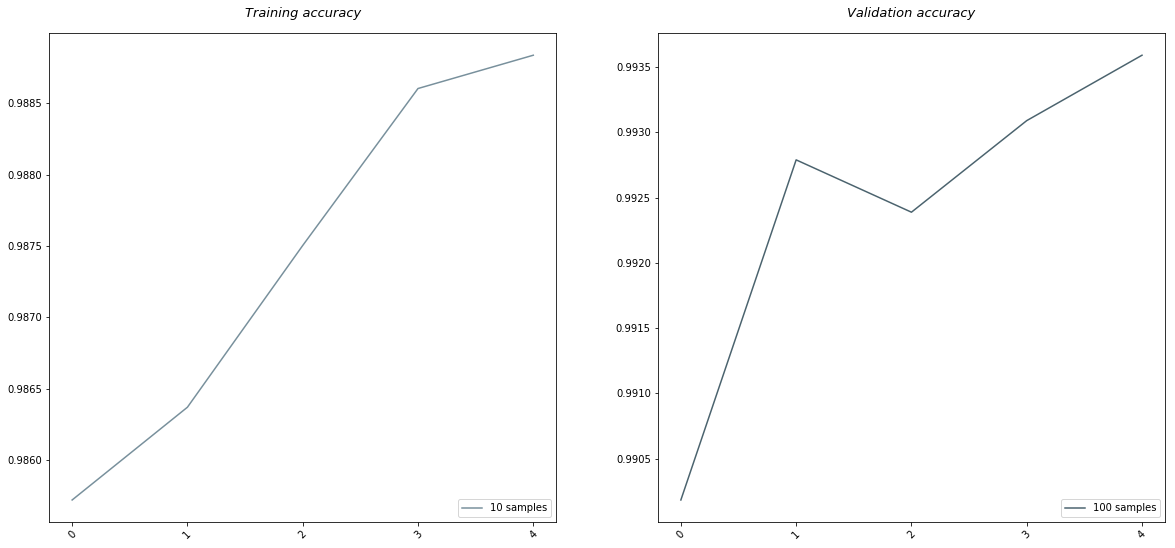

/Users/vikrant/anaconda3/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [205]:

figure = plt.figure(figsize=(20,9))
 
subplot = figure.add_subplot(1, 2, 1)
plt.plot(mfg.history['acc'], color='#78909c', label='10 samples')
#plt.ylim(0.8,1.09)
tick_marks = np.arange(5)
plt.xticks(tick_marks, range(5), rotation=45)
plt.title("Training accuracy", fontsize=13,fontweight=0, color='black', style='italic', y=1.02)
plt.legend(loc='lower right')

subplot = figure.add_subplot(1, 2, 2)
plt.plot(mfg.history['val_acc'], color='#4b636e', label='100 samples')
tick_marks = np.arange(5)
plt.xticks(tick_marks, range(5), rotation=45)
plt.title("Validation accuracy", fontsize=13,fontweight=0, color='black', style='italic', y=1.02)
plt.legend(loc='lower right')